<a href="https://colab.research.google.com/github/PioDru/colab/blob/main/breast_usg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#!/bin/bash
!curl -L -o ./breast-usg.zip https://www.kaggle.com/api/v1/datasets/download/aryashah2k/breast-ultrasound-images-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  194M  100  194M    0     0  74.7M      0  0:00:02  0:00:02 --:--:--  102M


In [21]:
!unzip -q ./breast-usg.zip  -d breast-usg

replace breast-usg/Dataset_BUSI_with_GT/benign/benign (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


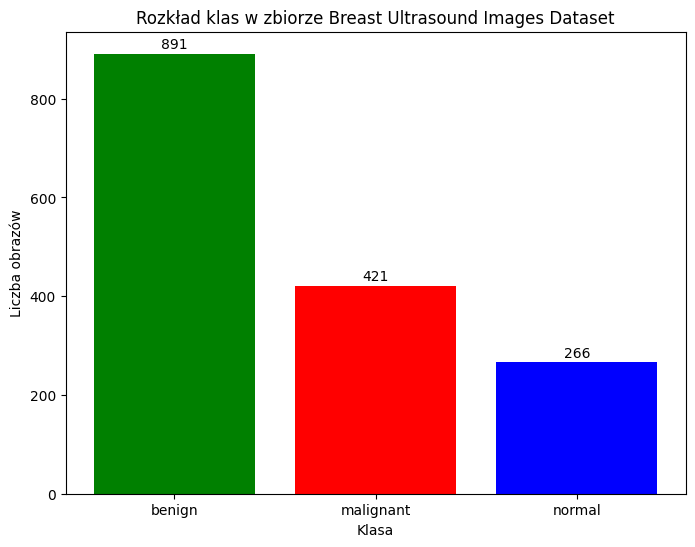

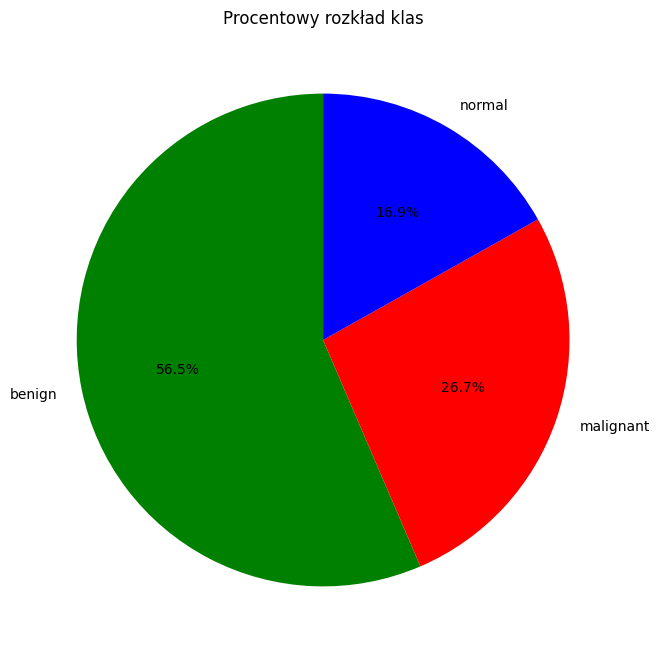

In [89]:
import matplotlib.pyplot as plt
import os

base_dir = '/content/breast-usg/Dataset_BUSI_with_GT'

# Dane: liczba obrazów dla każdej klasy
classes = ['benign', 'malignant', 'normal']
counts = [0, 0, 0]

for i, cls in enumerate(classes): # Use enumerate to get the index
    folder = os.path.join(base_dir, cls)
    if os.path.exists(folder):
        # Liczymy tylko pliki z rozszerzeniami obrazów
        num_files = len([f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        counts[i] = num_files # Update counts using the index
    else:
        counts[i] = 0 # Update counts using the index

# Wykres słupkowy
plt.figure(figsize=(8,6))
bars = plt.bar(classes, counts, color=['green', 'red', 'blue'])  # Store the bar objects
plt.xlabel('Klasa')
plt.ylabel('Liczba obrazów')
plt.title('Rozkład klas w zbiorze Breast Ultrasound Images Dataset')

# Add labels above bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 5,  # Adjust position as needed
             str(count), ha='center', va='bottom')

plt.show()

# Wykres kołowy
plt.figure(figsize=(8,8))
plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90, colors=['green', 'red', 'blue'])
plt.title('Procentowy rozkład klas')
plt.show()

Rozkład klas przed balansowaniem:
class
benign       437
malignant    210
normal       133
Name: count, dtype: int64

Rozkład klas po oversamplingu:
class
benign       437
malignant    437
normal       437
Name: count, dtype: int64

Liczba próbek w podziale:
Treningowy: 917
Walidacyjny: 197
Testowy: 197


<ipython-input-90-a87a994f0d4c>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_all.groupby('class', group_keys=False).apply(


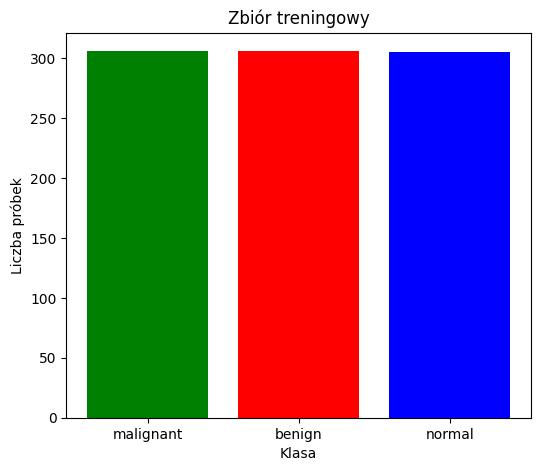

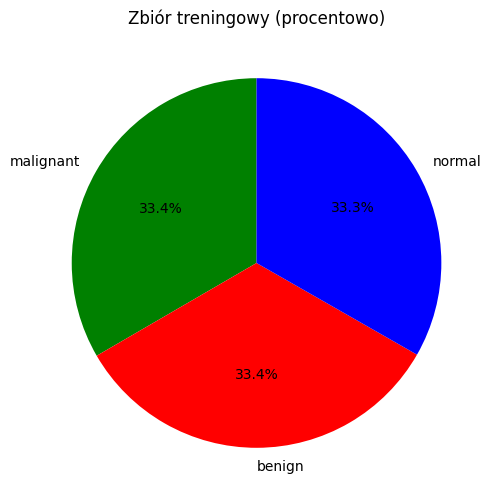

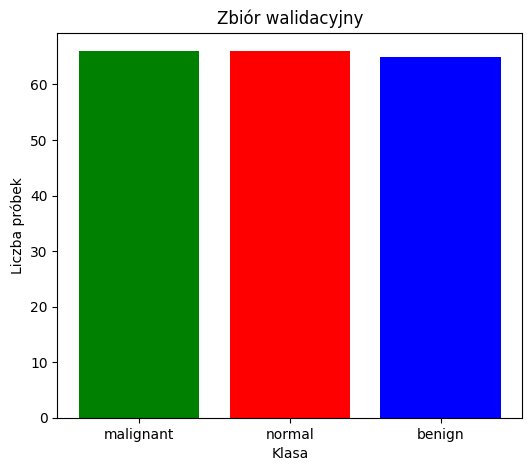

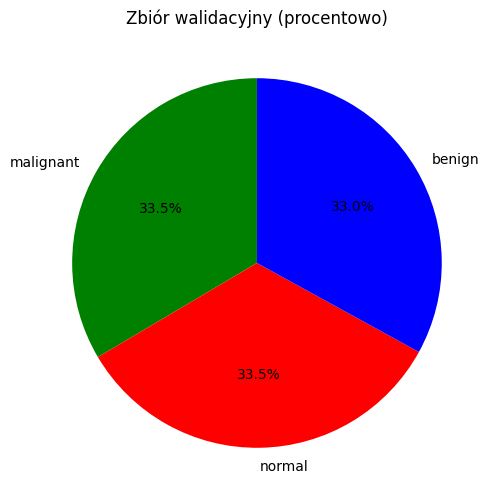

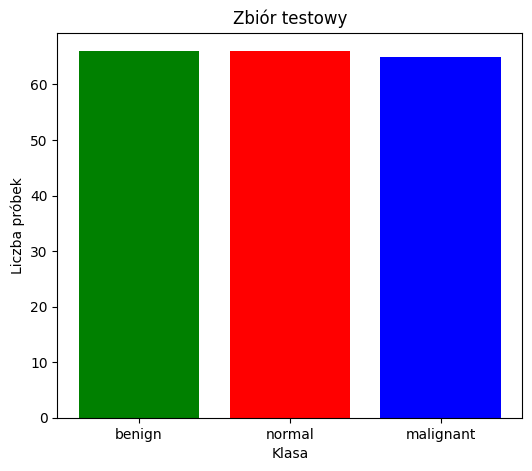

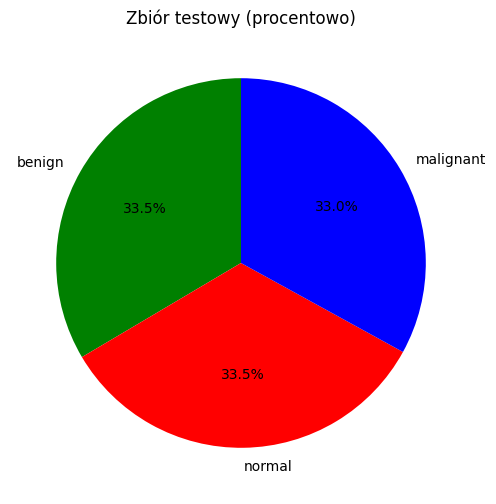

In [90]:
#balansowanie danych + oversampling

import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Ścieżka do głównego katalogu zbioru danych (np. struktura: dataset_path/benign, dataset_path/malignant, dataset_path/normal)
dataset_path = "/content/breast-usg/Dataset_BUSI_with_GT"  # np. "./Breast-Ultrasound-Images-Dataset"

classes = ['benign', 'malignant', 'normal']
dataframes = []

for cls in classes:
    # Pobieramy wszystkie pliki PNG z folderu danej klasy
    files = glob.glob(os.path.join(dataset_path, cls, "*.png"))
    # Pomijamy pliki zawierające "mask" w nazwie, jeśli chcemy pracować z oryginalnymi obrazami
    files = [f for f in files if "mask" not in os.path.basename(f).lower()]
    df_cls = pd.DataFrame({'filepath': files, 'class': cls})
    dataframes.append(df_cls)

# Łączymy dane ze wszystkich klas
df_all = pd.concat(dataframes, ignore_index=True)
print("Rozkład klas przed balansowaniem:")
print(df_all['class'].value_counts())

# Oversampling: dla każdej klasy powielamy próbki (losowo z powtórzeniami) tak, aby liczba próbek dla każdej klasy była równa max_count
max_count = df_all['class'].value_counts().max()

df_balanced = df_all.groupby('class', group_keys=False).apply(
    lambda x: x.sample(n=max_count, replace=True, random_state=42)
).reset_index(drop=True)

print("\nRozkład klas po oversamplingu:")
print(df_balanced['class'].value_counts())

# Podział zbalansowanego zbioru na dane treningowe (70%), walidacyjne (15%) i testowe (15%) z użyciem stratifikacji
train_df, temp_df = train_test_split(
    df_balanced, test_size=0.30, random_state=42, stratify=df_balanced['class']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42, stratify=temp_df['class']
)

print("\nLiczba próbek w podziale:")
print("Treningowy:", train_df.shape[0])
print("Walidacyjny:", val_df.shape[0])
print("Testowy:", test_df.shape[0])

# Wizualizacja rozkładu klas w poszczególnych zbiorach
def plot_class_distribution(df, title):
    counts = df['class'].value_counts()
    plt.figure(figsize=(6,5))
    plt.bar(counts.index, counts.values, color=['green', 'red', 'blue'])
    plt.xlabel('Klasa')
    plt.ylabel('Liczba próbek')
    plt.title(title)
    plt.show()

    plt.figure(figsize=(6,6))
    plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=90,
            colors=['green', 'red', 'blue'])
    plt.title(title + " (procentowo)")
    plt.show()

plot_class_distribution(train_df, "Zbiór treningowy")
plot_class_distribution(val_df, "Zbiór walidacyjny")
plot_class_distribution(test_df, "Zbiór testowy")


Rozkład klas w całości zbioru:
class
benign       437
malignant    210
normal       133
Name: count, dtype: int64

Liczba próbek - trening: 917, walidacja: 197, test: 197
Found 917 validated image filenames belonging to 3 classes.
Found 197 validated image filenames belonging to 3 classes.
Found 197 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_56 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_57 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_58 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_59 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1024)                │       6,423,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,927,555 (26.43 MB)

 Trainable params: 6,927,555 (26.43 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 532ms/step - accuracy: 0.3648 - loss: 1.0940 - val_accuracy: 0.4688 - val_loss: 1.0469 - learning_rate: 1.0000e-04
Epoch 2/30
 1/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2500 - loss: 1.1243

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.2500 - loss: 1.1243 - val_accuracy: 0.4375 - val_loss: 1.0462 - learning_rate: 1.0000e-04
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 742ms/step - accuracy: 0.3962 - loss: 1.0717 - val_accuracy: 0.4115 - val_loss: 1.0310 - learning_rate: 1.0000e-04
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5000 - loss: 1.0321 - val_accuracy: 0.4375 - val_loss: 1.0236 - learning_rate: 1.0000e-04
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 744ms/step - accuracy: 0.4494 - loss: 1.0351 - val_accuracy: 0.4323 - val_loss: 1.0552 - learning_rate: 1.0000e-04
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6250 - loss: 0.8657 - val_accuracy: 0.4219 - val_loss: 1.0923 - learning_rate: 1.0000e-04
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 456ms/step - accuracy: 0.4947 - loss: 1.0143 - val_accuracy: 0.5938 - val_loss: 0.9071 - learning_rate: 1.0000e-04
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5625 - los

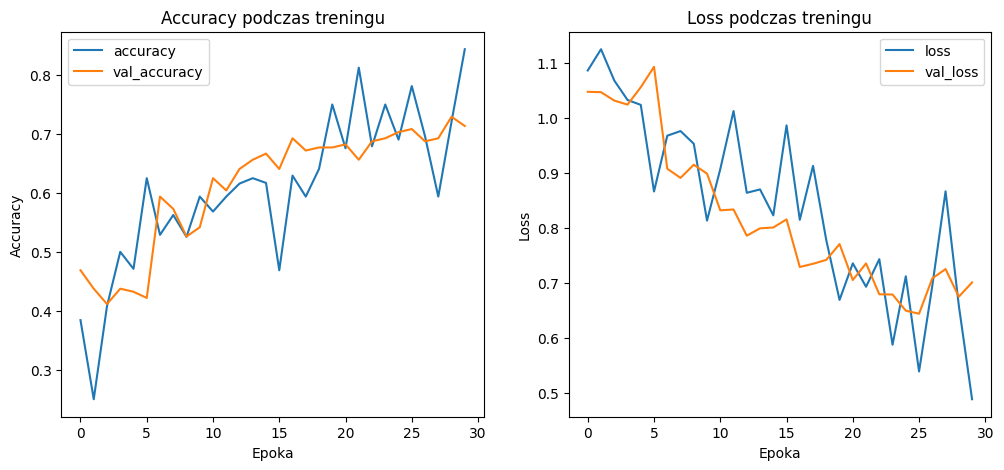

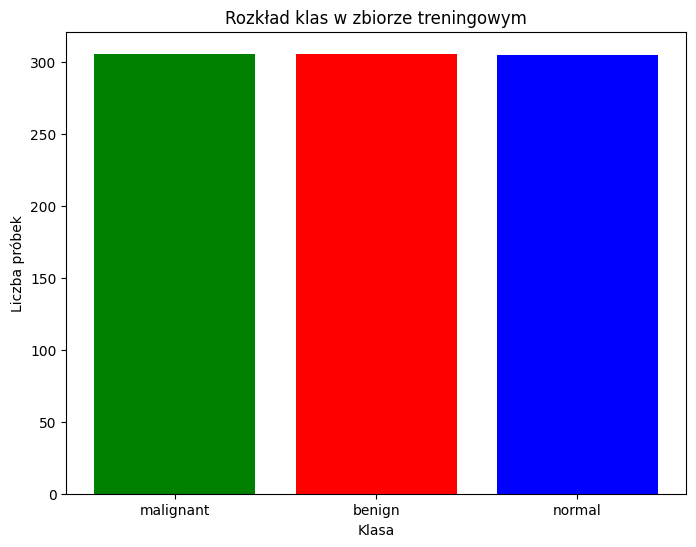

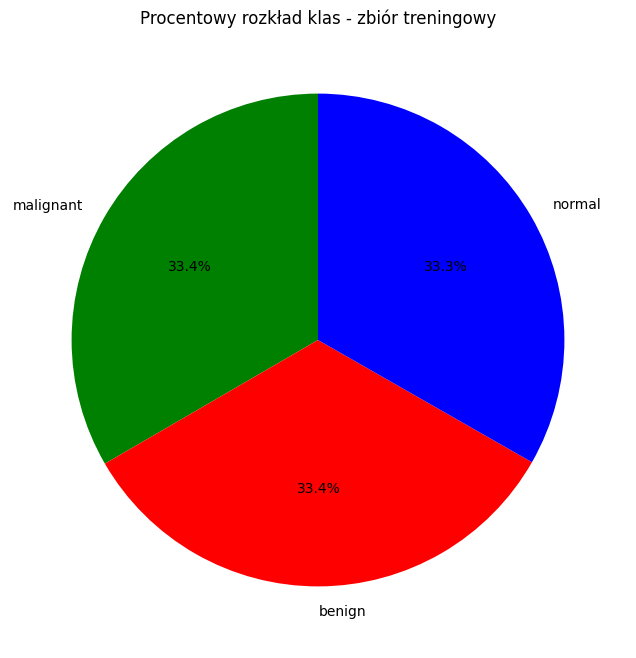

In [91]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df = pd.DataFrame(data, columns=["filepath", "class"]) # Explicitly name the columns

print("Rozkład klas w całości zbioru:")
print(df['class'].value_counts())

# Zakodowanie etykiet (np. jako liczby)
label_map = {'benign': '0', 'malignant': '1', 'normal': '2'}
df['label'] = df['class'].map(label_map)
train_df['label'] = train_df['class'].map(label_map) # Dodanie kolumny 'label' do train_df
val_df['label'] = val_df['class'].map(label_map)     # Dodanie kolumny 'label' do val_df
test_df['label'] = test_df['class'].map(label_map)    # Dodanie kolumny 'label' do test_df

# Podział zbioru na treningowy (70%), walidacyjny (15%) i testowy (15%) z zachowaniem rozkładu klas
#train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df['label'])
#val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df['label'])

print(f"\nLiczba próbek - trening: {train_df.shape[0]}, walidacja: {val_df.shape[0]}, test: {test_df.shape[0]}")

# Funkcja wczytująca i przetwarzająca obraz
IMG_SIZE = (150, 150)

def preprocess_image(filepath, label):
    # Wczytanie pliku obrazu
    image = tf.io.read_file(filepath)
    # Dekodowanie obrazu (zakładamy PNG)
    image = tf.image.decode_png(image, channels=3)
    # Zmiana rozmiaru obrazu
    image = tf.image.resize(image, IMG_SIZE)
    # Normalizacja do [0,1]
    image = image / 255.0
    return image, label

# Funkcja tworząca tf.data.Dataset z listy ścieżek i etykiet
def df_to_dataset(df, shuffle=True, batch_size=32):
    paths = df['filepath'].values
    labels = df['label'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: preprocess_image(x, y),
                num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Przygotowanie generatorów danych z augmentacją dla treningu
train_datagen = ImageDataGenerator(
    rescale=1./255,          # normalizacja pikseli
    rotation_range=15,       # losowe obroty
    width_shift_range=0.15,   # przesunięcia w poziomie
    height_shift_range=0.15,  # przesunięcia w pionie
    shear_range=0.15,         # transformacja skośna
    zoom_range=0.15,          # powiększenia
    horizontal_flip=False,    # odbicie lustrzane
    vertical_flip=False,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    #pd.concat([train_df, train_df]),
    x_col="filepath",  # Specify the column containing image paths
    y_col="label",  # Specify the column containing labels
    target_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle = True,               # True - zdjęcia będą losowo mieszane w całym zbiorze
    class_mode='sparse'
)

validation_generator = validation_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",  # Specify the column containing image paths
    y_col="label",  # Specify the column containing labels
    target_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle = False,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",  # Specify the column containing image paths
    y_col="label",  # Specify the column containing labels
    target_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle = False,
    class_mode='sparse'
)

train_ds = df_to_dataset(train_df, shuffle=True, batch_size=batch_size)
val_ds   = df_to_dataset(val_df, shuffle=False, batch_size=batch_size)
test_ds  = df_to_dataset(test_df, shuffle=False, batch_size=batch_size)

# Definicja modelu CNN przy użyciu tf.keras (przykładowa, można modyfikować)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 klasy
])

model.compile(
    loss='sparse_categorical_crossentropy',
    #optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
    )

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    #patience=4,          # Number of epochs to wait before stopping
    patience=5,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

model_checkpoint = ModelCheckpoint(
    filepath='breast_usg_model.keras',  # Use .keras extension
    monitor='val_accuracy',       # Metric to monitor
    save_best_only=True,          # Save only the best model
    mode='max'                    # Maximize the monitored metric
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Reduce learning rate by a factor of 0.1
    #patience=3           # Number of epochs to wait before reducing LR
    patience=5           # Number of epochs to wait before reducing LR
)

'''
# Trenowanie modelu
history = model.fit(
    train_ds,
    epochs=30,
    steps_per_epoch=len(train_ds) // batch_size,
    validation_data=val_ds,
    validation_steps=len(val_ds) // batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Add callbacks here
)
'''

# Trenowanie modelu
history = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Add callbacks here
)

# Ocena modelu na zbiorze testowym
#test_loss, test_acc = model.evaluate(test_ds)
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest accuracy: {test_acc:.2f}")

model.save('breast_usg_model.keras')

# Wizualizacja historii trenowania
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoka')
plt.ylabel('Accuracy')
plt.title('Accuracy podczas treningu')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.title('Loss podczas treningu')
plt.legend()
plt.show()

# Wizualizacja rozkładu klas w zbiorze treningowym
train_counts = train_df['class'].value_counts()
plt.figure(figsize=(8,6))
plt.bar(train_counts.index, train_counts.values, color=['green', 'red', 'blue'])
plt.xlabel('Klasa')
plt.ylabel('Liczba próbek')
plt.title('Rozkład klas w zbiorze treningowym')
plt.show()

plt.figure(figsize=(8,8))
plt.pie(train_counts.values, labels=train_counts.index, autopct='%1.1f%%', startangle=90,
        colors=['green', 'red', 'blue'])
plt.title('Procentowy rozkład klas - zbiór treningowy')
plt.show()

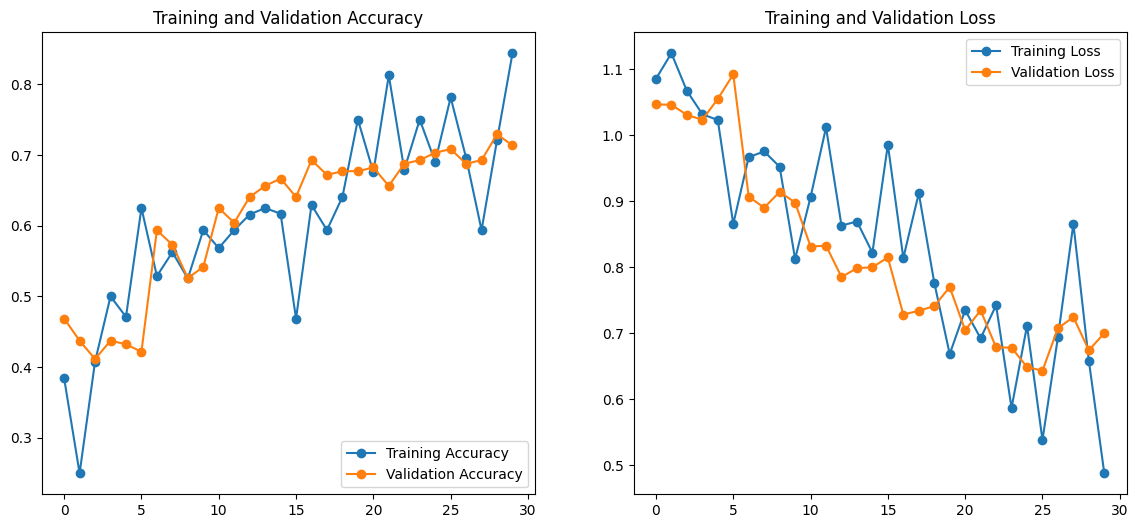

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.7654 - loss: 0.5695
Test Accuracy: 78.17%
Test Loss: 0.5604
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.7654 - loss: 0.5695
Test Accuracy: 78.17%
Test Loss: 0.5604
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Confusion Matrix:
[[48  9  9]
 [ 8 52  5]
 [10  4 52]]


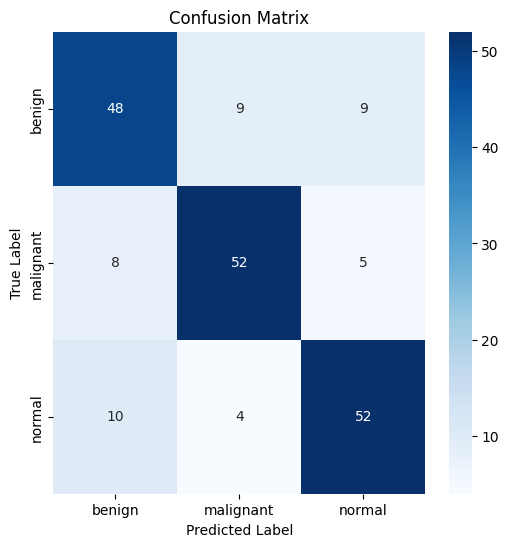

accuracy: 0.7716
recall: 0.7716
precision: 0.7716
f1: 0.7716
roc_auc: 0.8286


In [92]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Zakładamy, że obiekt `history` został zwrócony przez model.fit
# history = model.fit(...)

# Wykres accuracy i loss dla danych treningowych oraz walidacyjnych
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Ocena modelu na zbiorze testowym
#test_loss, test_accuracy = model.evaluate(test_ds)
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Loss: {:.4f}".format(test_loss))

# Obliczenie macierzy pomyłek
# Upewnij się, że test_generator nie miesza kolejności, resetujemy go
#test_ds.reset()
#predictions = model.predict(test_ds)
predictions = model.predict(test_generator)
# Zakładamy, że mamy klasyfikację binarną z funkcją aktywacji sigmoid
#test_loss, test_accuracy = model.evaluate(test_ds)
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Loss: {:.4f}".format(test_loss))

# Obliczenie macierzy pomyłek
# Pobranie wszystkich etykiet i predykcji ze zbioru testowego
y_true = []
y_pred = []
for images, labels in test_ds:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Pobranie indeksu klasy o największym prawdopodobieństwie
    y_true.extend(labels.numpy().astype(int))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(6, 6))
class_names = list(label_map.keys())  # Assuming label_map was defined earlier
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print('accuracy: {:.4f}'.format(accuracy_score(y_true, y_pred)))
print('recall: {:.4f}'.format(recall_score(y_true, y_pred, average='weighted'))) # Changed to 'weighted'
print('precision: {:.4f}'.format(precision_score(y_true, y_pred, average='weighted'))) # Changed to 'weighted'
print('f1: {:.4f}'.format(f1_score(y_true, y_pred, average='weighted'))) # Changed to 'weighted'

# ROC AUC score requires one-hot encoding for multi-class
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])
print('roc_auc: {:.4f}'.format(roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr'))) # Changed to 'weighted' and added multi_class parameter


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step


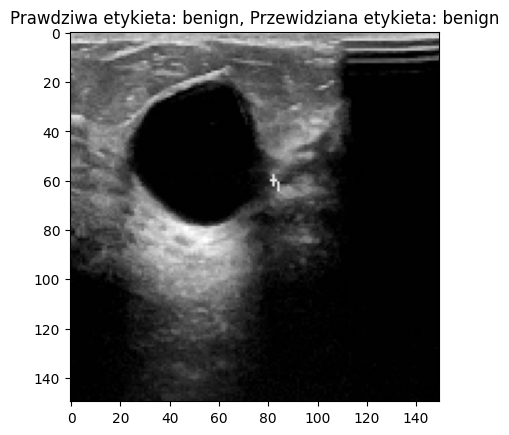

Prawdopodobieństwa klas: [8.0716848e-01 1.9264458e-01 1.8698588e-04]
Klasy: ['benign', 'malignant', 'normal']


In [93]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

image_path = "/content/breast-usg/Dataset_BUSI_with_GT/benign/benign (9).png"  # Zastąp swoją ścieżką

# Pobierz prawdziwą etykietę na podstawie ścieżki

true_label = os.path.basename(os.path.dirname(image_path))

# Wczytaj i przetwórz obraz
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE[0], IMG_SIZE[1]))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Dodaj wymiar wsadu
img_array = img_array / 255.0  # Normalizacja

# Predykcja
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction[0])

# Odwrotne mapowanie indeksu klasy na nazwę klasy
label_map_reversed = {v: k for k, v in label_map.items()}  # label_map z poprzedniego kodu
predicted_class = label_map_reversed[str(predicted_class_index)]

# Wyświetl wyniki
plt.imshow(img)
plt.title(f"Prawdziwa etykieta: {true_label}, Przewidziana etykieta: {predicted_class}")
plt.show()

print(f"Prawdopodobieństwa klas: {prediction[0]}")
print(f"Klasy: {classes}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


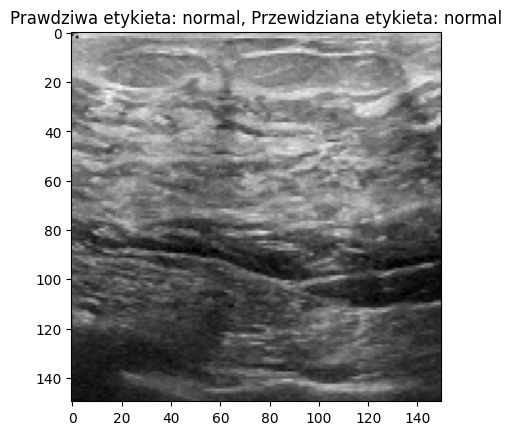

Prawdopodobieństwa klas: [0.18409151 0.13443895 0.68146956]
Klasy: ['benign', 'malignant', 'normal']


In [94]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

image_path = "/content/breast-usg/Dataset_BUSI_with_GT/normal/normal (96).png"  # Zastąp swoją ścieżką

# Pobierz prawdziwą etykietę na podstawie ścieżki

true_label = os.path.basename(os.path.dirname(image_path))

# Wczytaj i przetwórz obraz
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE[0], IMG_SIZE[1]))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Dodaj wymiar wsadu
img_array = img_array / 255.0  # Normalizacja

# Predykcja
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction[0])

# Odwrotne mapowanie indeksu klasy na nazwę klasy
label_map_reversed = {v: k for k, v in label_map.items()}  # label_map z poprzedniego kodu
predicted_class = label_map_reversed[str(predicted_class_index)]

# Wyświetl wyniki
plt.imshow(img)
plt.title(f"Prawdziwa etykieta: {true_label}, Przewidziana etykieta: {predicted_class}")
plt.show()

print(f"Prawdopodobieństwa klas: {prediction[0]}")
print(f"Klasy: {classes}")


(150, 150)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


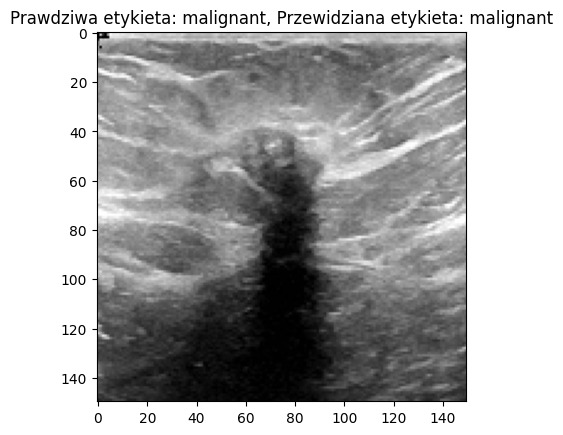

Prawdopodobieństwa klas: [0.12427137 0.8737446  0.00198397]
Klasy: ['benign', 'malignant', 'normal']


In [95]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

image_path = "/content/breast-usg/Dataset_BUSI_with_GT/malignant/malignant (90).png"  # Zastąp swoją ścieżką

# Pobierz prawdziwą etykietę na podstawie ścieżki

true_label = os.path.basename(os.path.dirname(image_path))

print(IMG_SIZE)

# Wczytaj i przetwórz obraz
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_SIZE[0], IMG_SIZE[1]))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Dodaj wymiar wsadu
img_array = img_array / 255.0  # Normalizacja

# Predykcja
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction[0])

# Odwrotne mapowanie indeksu klasy na nazwę klasy
label_map_reversed = {v: k for k, v in label_map.items()}  # label_map z poprzedniego kodu
predicted_class = label_map_reversed[str(predicted_class_index)]

# Wyświetl wyniki
plt.imshow(img)
plt.title(f"Prawdziwa etykieta: {true_label}, Przewidziana etykieta: {predicted_class}")
plt.show()

print(f"Prawdopodobieństwa klas: {prediction[0]}")
print(f"Klasy: {classes}")
